In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt

In [2]:
in_dir = r'..\..\coculture_diagonal\primed_pbmc\primed_pbmc_cd8\primed_pbmc_cd8'
fn_l = os.listdir(in_dir)
fn_l.sort()

In [3]:
# for fn in fn_l:
#     os.rename(os.path.join(in_dir,fn),os.path.join(in_dir,'msc_primed-t0_tnfa_pdl1_col5a2_0'+fn))

In [4]:
processed_dir = os.path.join(in_dir,'processed')
fn_l = os.listdir(in_dir)
fn_l.sort()
for fn in fn_l:
    if fn.endswith('.nd2'):
        name = fn.split('.')[0]
        os.makedirs(os.path.join(processed_dir,name))

In [ ]:
processed_dir = os.path.join(in_dir,'processed')
fn_l = os.listdir(in_dir)
fn_l.sort()
for i in range(120):
    os.makedirs(os.path.join(processed_dir,str(i).zfill(3)))

# Check out of focus images for reimaging

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from scipy.ndimage import gaussian_gradient_magnitude
import os
import tifffile

In [4]:
in_dir = r'..\..\coculture_diagonal\primed_cd8\primed_cd8_cycle2\processed'
fov_l = os.listdir(in_dir)
fov_l.sort()

In [ ]:
test_im_stack = tifffile.imread(os.path.join(in_dir,'001','C4_001.tif'))

In [ ]:
test_im_stack.shape


(61, 2304, 2304)

In [ ]:
print(np.sum(gaussian_gradient_magnitude(test_im_stack[0,:,:], sigma=1.0)**2))
print(np.sum(gaussian_gradient_magnitude(test_im_stack[60,:,:], sigma=1.0)**2))
print(np.sum(gaussian_gradient_magnitude(test_im_stack[31,:,:], sigma=1.0)**2))

804359734
3087255873
1665516137


In [ ]:
test_mip = tifffile.imread(os.path.join(in_dir,'001','MAX_C4_001.tif'))

In [ ]:
print(np.sum(gaussian_gradient_magnitude(test_mip, sigma=1.0)**2))

23497067


In [ ]:
filters.tenengrad(test_im_stack[0,:,:])
filters.tenengrad(test_im_stack[30,:,:])
filters.tenengrad(test_im_stack[60,:,:])

AttributeError: No skimage.filters attribute tenengrad

# Registtration

In [3]:
import numpy as np
import tifffile
from skimage.registration import phase_cross_correlation
from skimage.exposure import rescale_intensity
from skimage.filters import gaussian
from skimage.util import img_as_uint,img_as_float
from skimage.transform import warp_polar, rotate
from skimage.feature import match_template
from skimage.filters import gaussian


from skimage.filters import threshold_otsu
from tqdm import tqdm

from joblib import Parallel, delayed

import os

In [6]:
def register_imgs(ims, stacks):
    # This function takes a list of image stacks, and takes the first image in the stack as a registration references
    
    for i in range(len(ims)-1,0,-1):
        # Find translational shift
        move = ims[i][:,:,0]
        station = ims[i-1][:,:,0]

        shift, _, _ = phase_cross_correlation(station, move)
        shift = shift.astype('int')

        if shift[0] < 0:
            for m in range(i,len(ims)):
                ims[m] = ims[m][-shift[0]:,:,:]
                stacks[m] = stacks[m][-shift[0]:,:,:,:]
            for n in range(i):
                ims[n] = ims[n][:ims[i].shape[0],:,:]
                stacks[n] = stacks[n][:stacks[i].shape[0],:,:,:]
        if shift[0] > 0:
            for n in range(i):
                ims[n] = ims[n][shift[0]:,:,:]
                stacks[n] = stacks[n][shift[0]:,:,:,:]
            for m in range(i,len(ims)):
                ims[m] = ims[m][:ims[i-1].shape[0],:,:]
                stacks[m] = stacks[m][:stacks[i-1].shape[0],:,:,:]
        if shift[1] < 0:
            for m in range(i,len(ims)):
                ims[m] = ims[m][:,-shift[1]:,:]
                stacks[m] = stacks[m][:,-shift[1]:,:,:]
            for n in range(i):
                ims[n] = ims[n][:,:ims[i].shape[1],:]
                stacks[n] = stacks[n][:,:stacks[i].shape[1],:,:]
        if shift[1] > 0:
            for n in range(i):
                ims[n] = ims[n][:,shift[1]:,:]
                stacks[n] = stacks[n][:,shift[1]:,:,:]
            for m in range(i,len(ims)):
                ims[m] = ims[m][:,:ims[i-1].shape[1],:]
                stacks[m] = stacks[m][:,:stacks[i-1].shape[1],:,:]

    # Find rotation shift between last cycle
    """
    station = ims[len(ims)-2][:,:,0]
    move = ims[len(ims)-1][:,:,0]

    radius = 750

    move_polar = warp_polar(move, radius = radius)
    station_polar = warp_polar(station, radius = radius)

    polar_shift,_,_ = phase_cross_correlation(move_polar, station_polar)
    angle = polar_shift[0]

    ims[len(ims)-1] = rotate(ims[len(ims)-1], angle=angle)
    """

    new_ims = Parallel(n_jobs=4)(delayed(img_as_uint)(i) for i in zip(ims))
    new_stacks = Parallel(n_jobs=4)(delayed(img_as_uint)(i) for i in zip(stacks))

    return new_ims, new_stacks

In [5]:
in_dir = r'..\..\coculture_diagonal\primed_pbmc'

In [6]:
cycles_to_process = ['primed_pbmc','primed_pbmc_cycle2']

In [7]:
fov_l = [str(i).zfill(3) for i in range(120)]

## single-fov test

In [ ]:
cycle1_mip = []
cycle1_stack = []
im_l = os.listdir(os.path.join(in_dir, cycles_to_process[0], 'processed','005'))
im_l.sort()
for im in im_l:
    if 'MAX' in im:
        cycle1_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed','005',im))))
    if 'back_sub_stack' in im:
        
        img = tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed','005',im))
        img = img.transpose(1,2,0)
        cycle1_stack.append(img)

In [ ]:
cycle1_reg_ref = np.stack(cycle1_mip[1:],axis=2)
cycle1_reg_ref = gaussian(np.max(cycle1_reg_ref,axis=2), sigma=3, multichannel=True)
cycle1_mip = np.stack([cycle1_reg_ref]+cycle1_mip,axis=2)
cycle1_stack = np.stack(cycle1_stack,axis=3)

In [ ]:
cycle2_mip = []
cycle2_stack = []
im_l = os.listdir(os.path.join(in_dir,cycles_to_process[1],'processed','006'))
im_l.sort()
for im in im_l:
    if 'MAX' in im:
        cycle2_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed','006',im))))
    if 'back_sub_stack' in im:
        img = tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed','006',im))
        img = img.transpose(1,2,0)
        cycle2_stack.append(img)

In [ ]:
cycle2_reg_ref = np.stack(cycle2_mip[1:],axis=2)
cycle2_reg_ref = gaussian(np.max(cycle2_reg_ref,axis=2), sigma=3, multichannel=True)
cycle2_mip = np.stack([cycle2_reg_ref]+cycle2_mip,axis=2)
cycle2_stack = np.stack(cycle2_stack,axis=3)

In [ ]:
cycle1_mip.shape

(2304, 2304, 5)

In [ ]:
cycle2_mip.shape

(2304, 2304, 5)

In [ ]:
registered_mip,registered_stack = register_imgs([cycle1_mip,cycle2_mip],[cycle1_stack,cycle2_stack])

In [ ]:
registered_mip[0].shape

(1, 2262, 2240, 5)

In [ ]:
registered_stack[0].shape

(1, 2262, 2240, 61, 4)

In [ ]:
for i in range(2):
    registered_mip[i] = registered_mip[i].squeeze()
    registered_stack[i] = registered_stack[i].squeeze()

In [ ]:
out_dir = r'..\test_processing\registration'
for i in range(5):
    tifffile.imwrite(os.path.join(out_dir,'cycle1_mip_C'+str(i+1)+'.tif'),registered_mip[0][:,:,i],imagej=True)
    tifffile.imwrite(os.path.join(out_dir,'cycle2_mip_C'+str(i+1)+'.tif'),registered_mip[1][:,:,i],imagej=True)

In [ ]:
registered_stack[0].shape

(2262, 2240, 61, 4)

In [ ]:
registered_mip[0].shape

(2262, 2240, 5)

In [ ]:
out_dir = r'..\test_processing\registration'
for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,'cycle1_stack_C'+str(i+1)+'.tif'),
                         registered_stack[0][:,:,:,i].transpose(2,0,1),imagej=True)
        tifffile.imwrite(os.path.join(out_dir,'cycle2_stack_C'+str(i+1)+'.tif'),
                         registered_stack[1][:,:,:,i].transpose(2,0,1),imagej=True)

## Cycle 1, 2 registration, batch

In [4]:
in_dir = r'..\..\coculture_diagonal\primed_cd8'
cycles_to_process = ['primed_cd8','primed_cd8_cycle2']
fov_l = [str(i).zfill(3) for i in range(120)]

out_dir = r'..\..\coculture_diagonal\primed_cd8\00_registered\RNA'
for fov in fov_l:
    os.makedirs(os.path.join(out_dir,fov))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '..\\..\\coculture_diagonal\\primed_cd8\\00_registered\\RNA\\001'

In [ ]:
for fov in tqdm(fov_l):
    cycle1_mip = []
    cycle1_stack = []
    im_l = os.listdir(os.path.join(in_dir, cycles_to_process[0], 'processed',fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle1_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))
            img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
            cycle1_stack.append(img)
            
    cycle1_reg_ref = np.stack(cycle1_mip[1:],axis=2)
    cycle1_reg_ref = gaussian(np.max(cycle1_reg_ref,axis=2), sigma=3, multichannel=True)
    cycle1_mip = np.stack([cycle1_reg_ref]+cycle1_mip,axis=2)
    cycle1_stack = np.stack(cycle1_stack,axis=3)
    
    if fov=='000':
        cycle2_fov='001'
    else:
        cycle2_fov = str(int(fov.lstrip('0'))+1).zfill(3)
    cycle2_mip = []
    cycle2_stack = []
    im_l = os.listdir(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle2_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))
            img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
            cycle2_stack.append(img)
    
    cycle2_reg_ref = np.stack(cycle2_mip[1:],axis=2)
    cycle2_reg_ref = gaussian(np.max(cycle2_reg_ref,axis=2), sigma=3, multichannel=True)
    cycle2_mip = np.stack([cycle2_reg_ref]+cycle2_mip,axis=2)
    cycle2_stack = np.stack(cycle2_stack,axis=3)
    
    registered_mip,registered_stack = register_imgs([cycle1_mip,cycle2_mip],[cycle1_stack,cycle2_stack])
    
    for i in range(2):
        registered_mip[i] = registered_mip[i].squeeze()
        registered_stack[i] = registered_stack[i].squeeze()
    for i in range(5):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_mip_C'+str(i+1)+'.tif'),registered_mip[0][:,:,i],imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_mip_C'+str(i+1)+'.tif'),registered_mip[1][:,:,i],imagej=True)
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_stack_C'+str(i+1)+'.tif'),
                         registered_stack[0][:,:,:,i].transpose(2,0,1),imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_stack_C'+str(i+1)+'.tif'),
                         registered_stack[1][:,:,:,i].transpose(2,0,1),imagej=True)

100%|█████████████████████████████████████████████████████████████████████████████| 120/120 [3:47:29<00:00, 113.75s/it]


In [ ]:
# Reimaged fov registration:
fov_l = ['003', '008', '015', '020', '023', '033', '050', '052', '060', '064', '066', '080', '114']
for fov in tqdm(fov_l):
    cycle1_mip = []
    cycle1_stack = []
    im_l = os.listdir(os.path.join(in_dir, cycles_to_process[0], 'processed',fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle1_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))
            img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
            cycle1_stack.append(img)
            
    cycle1_reg_ref = np.stack(cycle1_mip[1:],axis=2)
    cycle1_reg_ref = gaussian(np.max(cycle1_reg_ref,axis=2), sigma=3, multichannel=True)
    cycle1_mip = np.stack([cycle1_reg_ref]+cycle1_mip,axis=2)
    cycle1_stack = np.stack(cycle1_stack,axis=3)
    
    if fov=='000':
        cycle2_fov='001'
    else:
        cycle2_fov = str(int(fov.lstrip('0'))+1).zfill(3)
    cycle2_mip = []
    cycle2_stack = []
    im_l = os.listdir(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle2_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))
            img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
            cycle2_stack.append(img)
    
    cycle2_reg_ref = np.stack(cycle2_mip[1:],axis=2)
    cycle2_reg_ref = gaussian(np.max(cycle2_reg_ref,axis=2), sigma=3, multichannel=True)
    cycle2_mip = np.stack([cycle2_reg_ref]+cycle2_mip,axis=2)
    cycle2_stack = np.stack(cycle2_stack,axis=3)
    
    registered_mip,registered_stack = register_imgs([cycle1_mip,cycle2_mip],[cycle1_stack,cycle2_stack])
    
    for i in range(2):
        registered_mip[i] = registered_mip[i].squeeze()
        registered_stack[i] = registered_stack[i].squeeze()
    for i in range(5):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_mip_C'+str(i+1)+'.tif'),registered_mip[0][:,:,i],imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_mip_C'+str(i+1)+'.tif'),registered_mip[1][:,:,i],imagej=True)
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_stack_C'+str(i+1)+'.tif'),
                         registered_stack[0][:,:,:,i].transpose(2,0,1),imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_stack_C'+str(i+1)+'.tif'),
                         registered_stack[1][:,:,:,i].transpose(2,0,1),imagej=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [26:12<00:00, 120.93s/it]


## dapi channel registration

In [14]:
in_dir = r'..\..\coculture_diagonal\primed_monocytes'
cycles_to_process = ['primed_monocytes','primed_monocytes_cycle2']
fov_l = [str(i).zfill(3) for i in range(120)]

out_dir = r'..\..\coculture_diagonal\primed_monocytes\00_registered\RNA'
for fov in fov_l:
    os.makedirs(os.path.join(out_dir,fov))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '..\\..\\coculture_diagonal\\primed_monocytes\\00_registered\\RNA\\000'

In [6]:
# pbmc registration:
for fov in tqdm(fov_l):
    cycle1_mip = []
    cycle1_stack = []
    im_l = os.listdir(os.path.join(in_dir, cycles_to_process[0], 'processed',fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle1_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))
            img = img.transpose(1,2,0)
            cycle1_stack.append(img)
            
    cycle1_mip = np.stack(cycle1_mip,axis=2)
    cycle1_stack = np.stack(cycle1_stack,axis=3)
    
    if fov=='000':
        cycle2_fov='001'
    else:
        cycle2_fov = str(int(fov.lstrip('0'))+1).zfill(3)
    cycle2_mip = []
    cycle2_stack = []
    im_l = os.listdir(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle2_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))
            img = img.transpose(1,2,0)
            cycle2_stack.append(img)
    
    cycle2_mip = np.stack(cycle2_mip,axis=2)
    cycle2_stack = np.stack(cycle2_stack,axis=3)
    
    registered_mip,registered_stack = register_imgs([cycle1_mip,cycle2_mip],[cycle1_stack,cycle2_stack])
    
    for i in range(2):
        registered_mip[i] = registered_mip[i].squeeze()
        registered_stack[i] = registered_stack[i].squeeze()
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_mip_C'+str(i+1)+'.tif'),registered_mip[0][:,:,i],imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_mip_C'+str(i+1)+'.tif'),registered_mip[1][:,:,i],imagej=True)
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_stack_C'+str(i+1)+'.tif'),
                         registered_stack[0][:,:,:,i].transpose(2,0,1),imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_stack_C'+str(i+1)+'.tif'),
                         registered_stack[1][:,:,:,i].transpose(2,0,1),imagej=True)

  0%|          | 0/120 [00:00<?, ?it/s]


FileNotFoundError: [WinError 3] The system cannot find the path specified: '..\\..\\coculture_diagonal\\primed_cd8\\primed_cd8\\processed\\000'

In [11]:
# cd8 registration:
out_dir = r'..\..\coculture_diagonal\primed_cd8\00_registered\RNA'
fov_l = os.listdir(out_dir)
for fov in tqdm(fov_l):
    cycle1_mip = []
    cycle1_stack = []
    im_l = os.listdir(os.path.join(in_dir, cycles_to_process[0], 'processed',fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle1_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))
            img = img.transpose(1,2,0)
            cycle1_stack.append(img)
            
    cycle1_mip = np.stack(cycle1_mip,axis=2)
    cycle1_stack = np.stack(cycle1_stack,axis=3)
    
    cycle2_fov = fov
    cycle2_mip = []
    cycle2_stack = []
    im_l = os.listdir(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle2_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))
            img = img.transpose(1,2,0)
            cycle2_stack.append(img)
    
    cycle2_mip = np.stack(cycle2_mip,axis=2)
    cycle2_stack = np.stack(cycle2_stack,axis=3)
    
    registered_mip,registered_stack = register_imgs([cycle1_mip,cycle2_mip],[cycle1_stack,cycle2_stack])
    
    for i in range(2):
        registered_mip[i] = registered_mip[i].squeeze()
        registered_stack[i] = registered_stack[i].squeeze()
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_mip_C'+str(i+1)+'.tif'),registered_mip[0][:,:,i],imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_mip_C'+str(i+1)+'.tif'),registered_mip[1][:,:,i],imagej=True)
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_stack_C'+str(i+1)+'.tif'),
                         registered_stack[0][:,:,:,i].transpose(2,0,1),imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_stack_C'+str(i+1)+'.tif'),
                         registered_stack[1][:,:,:,i].transpose(2,0,1),imagej=True)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [4:16:37<00:00, 128.31s/it] 


In [16]:
# monocytes registration:
out_dir = r'..\..\coculture_diagonal\primed_monocytes\00_registered\RNA'
fov_l = os.listdir(out_dir)
for fov in tqdm(fov_l):
    cycle1_mip = []
    cycle1_stack = []
    im_l = os.listdir(os.path.join(in_dir, cycles_to_process[0], 'processed',fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle1_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[0],'processed',fov,im))
            img = img.transpose(1,2,0)
            cycle1_stack.append(img)
            
    cycle1_mip = np.stack(cycle1_mip,axis=2)
    cycle1_stack = np.stack(cycle1_stack,axis=3)
    
    cycle2_fov = fov
    cycle2_mip = []
    cycle2_stack = []
    im_l = os.listdir(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov))
    im_l.sort()
    for im in im_l:
        if 'MAX' in im:
            cycle2_mip.append(img_as_float(tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))))
        if 'back_sub_stack' in im:
            img = tifffile.imread(os.path.join(in_dir,cycles_to_process[1],'processed',cycle2_fov,im))
            img = img.transpose(1,2,0)
            cycle2_stack.append(img)
    
    cycle2_mip = np.stack(cycle2_mip,axis=2)
    cycle2_stack = np.stack(cycle2_stack,axis=3)
    
    registered_mip,registered_stack = register_imgs([cycle1_mip,cycle2_mip],[cycle1_stack,cycle2_stack])
    
    for i in range(2):
        registered_mip[i] = registered_mip[i].squeeze()
        registered_stack[i] = registered_stack[i].squeeze()
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_mip_C'+str(i+1)+'.tif'),registered_mip[0][:,:,i],imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_mip_C'+str(i+1)+'.tif'),registered_mip[1][:,:,i],imagej=True)
    for i in range(4):
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle1_stack_C'+str(i+1)+'.tif'),
                         registered_stack[0][:,:,:,i].transpose(2,0,1),imagej=True)
        tifffile.imwrite(os.path.join(out_dir,fov,'cycle2_stack_C'+str(i+1)+'.tif'),
                         registered_stack[1][:,:,:,i].transpose(2,0,1),imagej=True)

100%|██████████| 120/120 [4:04:03<00:00, 122.03s/it] 


## IF markers registration

In [7]:
from skimage.feature import match_template
from scipy.ndimage import shift

In [42]:
# test
cycle2_ref = tifffile.imread(r'..\..\coculture_diagonal\primed_pbmc\00_registered\RNA\000\cycle2_mip_C1.tif')
mki_ref = tifffile.imread(r'..\..\coculture_diagonal\primed_pbmc\primed_pbmc_mki67\primed_pbmc_mki67\processed\001\MAX_C1_001.tif')

result = match_template(mki_ref, cycle2_ref)
best_match_loc = np.unravel_index(result.argmax(), result.shape)
matched_im = mki_ref[best_match_loc[0]:best_match_loc[0]+cycle2_ref.shape[0],
                     best_match_loc[1]:best_match_loc[1]+cycle2_ref.shape[1]]

shifts, _, _ = phase_cross_correlation(cycle2_ref, matched_im)
shifts = shifts.astype('int')
shift_x, shift_y = shifts

shifted_image = np.zeros_like(cycle2_ref)

shifted_image = shift(matched_im, (shift_x, shift_y))

radius = 750

move_polar = warp_polar(shifted_image, radius = radius)
station_polar = warp_polar(cycle2_ref, radius = radius)

polar_shift,_,_ = phase_cross_correlation(move_polar, station_polar)
angle = polar_shift[0]

rotated_image = rotate(shifted_image, angle=angle)

In [44]:
tifffile.imwrite(r'..\test_processing\registration\shifted_mki67.tif',shifted_image)
tifffile.imwrite(r'..\test_processing\registration\rotated_mki67.tif',img_as_uint(rotated_image))

In [36]:
tifffile.imwrite(r'..\test_processing\registration\template_matched_mki67.tif',matched_im)

In [8]:
def register_additional(fov,registered_dir,additional_dir,out_dir,cell_type,marker):
    if cell_type == 'pbmc':
        cycle2_fov = str(int(fov.lstrip())-1).zfill(3)
    else:
        cycle2_fov = fov
    cycle1_ref = tifffile.imread(os.path.join(registered_dir,cycle2_fov,'cycle1_mip_C1.tif'))
    mki_ref = tifffile.imread(os.path.join(additional_dir,fov,'MAX_C1_'+fov+'.tif'))
    mki_ch2 = tifffile.imread(os.path.join(additional_dir,fov,'MAX_C2_'+fov+'.tif'))
    mki_ch3 = tifffile.imread(os.path.join(additional_dir,fov,'MAX_C3_'+fov+'.tif'))
    mki_ch4 = tifffile.imread(os.path.join(additional_dir,fov,'MAX_C4_'+fov+'.tif'))
    
    result = match_template(mki_ref, cycle1_ref)
    best_match_loc = np.unravel_index(result.argmax(), result.shape)
    matched_ch1 = mki_ref[best_match_loc[0]:best_match_loc[0]+cycle1_ref.shape[0],
                         best_match_loc[1]:best_match_loc[1]+cycle1_ref.shape[1]]
    matched_ch2 = mki_ch2[best_match_loc[0]:best_match_loc[0]+cycle1_ref.shape[0],
                         best_match_loc[1]:best_match_loc[1]+cycle1_ref.shape[1]]
    matched_ch3 = mki_ch3[best_match_loc[0]:best_match_loc[0]+cycle1_ref.shape[0],
                         best_match_loc[1]:best_match_loc[1]+cycle1_ref.shape[1]]
    matched_ch4 = mki_ch4[best_match_loc[0]:best_match_loc[0]+cycle1_ref.shape[0],
                         best_match_loc[1]:best_match_loc[1]+cycle1_ref.shape[1]]
    
    shifts, _, _ = phase_cross_correlation(cycle1_ref, matched_ch1)
    shifts = shifts.astype('int')
    shift_x, shift_y = shifts
    
    shifted_ch1 = np.zeros_like(cycle1_ref)
    shifted_ch1 = shift(matched_ch1, (shift_x, shift_y))
    
    shifted_ch2 = np.zeros_like(cycle1_ref)
    shifted_ch2 = shift(matched_ch2, (shift_x, shift_y))
    
    shifted_ch3 = np.zeros_like(cycle1_ref)
    shifted_ch3 = shift(matched_ch3, (shift_x, shift_y))
    
    shifted_ch4 = np.zeros_like(cycle1_ref)
    shifted_ch4 = shift(matched_ch4, (shift_x, shift_y))
    
    radius = 750

    move_polar = warp_polar(shifted_ch1, radius = radius)
    station_polar = warp_polar(cycle1_ref, radius = radius)

    polar_shift,_,_ = phase_cross_correlation(move_polar, station_polar)
    angle = polar_shift[0]

    rotated_ch1 = rotate(shifted_ch1, angle=angle)
    rotated_ch2 = rotate(shifted_ch2, angle=angle)
    rotated_ch3 = rotate(shifted_ch3, angle=angle)
    rotated_ch4 = rotate(shifted_ch4, angle=angle)

    os.makedirs(os.path.join(out_dir,cycle2_fov))
    
    tifffile.imwrite(os.path.join(out_dir, cycle2_fov, 'C1_'+cycle2_fov+'_'+marker+'.tif'), img_as_uint(rotated_ch1), imagej=True)
    tifffile.imwrite(os.path.join(out_dir, cycle2_fov, 'C2_'+cycle2_fov+'_'+marker+'.tif'), img_as_uint(rotated_ch2), imagej=True)
    tifffile.imwrite(os.path.join(out_dir, cycle2_fov, 'C3_'+cycle2_fov+'_'+marker+'.tif'), img_as_uint(rotated_ch3), imagej=True)
    tifffile.imwrite(os.path.join(out_dir, cycle2_fov, 'C4_'+cycle2_fov+'_'+marker+'.tif'), img_as_uint(rotated_ch4), imagej=True)
    

### MKI67

In [9]:
registered_dir = r'..\..\coculture_diagonal\primed_monocytes\00_registered\RNA'
fov_l = os.listdir(registered_dir)
fov_l.sort()

mki_dir = r'..\..\coculture_diagonal\primed_monocytes\primed_monocytes_mki67\primed_monocytes_mki67\processed'
mki_fov_l = os.listdir(mki_dir)
mki_fov_l.sort()

out_dir = r'..\..\coculture_diagonal\primed_monocytes\00_registered\MKI67'

In [50]:
_ = Parallel(n_jobs=4,verbose=16)(delayed(register_additional)(fov,registered_dir,mki_dir,out_dir,'monocytes','MKI67') for fov in tqdm(mki_fov_l))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   16.5s

[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.7s

[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   43.2s

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   48.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   48.9s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.0min

[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  1.0min
[Para

### CD4, CD8, CD68

In [10]:
registered_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\RNA'
fov_l = os.listdir(registered_dir)
fov_l.sort()

cd4_dir = r'..\..\coculture_diagonal\primed_pbmc\primed_pbmc_cd8\primed_pbmc_cd8\processed'
cd4_fov_l = os.listdir(cd4_dir)
cd4_fov_l.sort()

out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\CD8'

In [37]:
_ = Parallel(n_jobs=4,verbose=16)(delayed(register_additional)(fov,registered_dir,cd4_dir,out_dir,'pbmc','CD8') for fov in tqdm(cd4_fov_l))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   40.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   58.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   59.7s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  1.3min
[Parallel(

### KI67

In [5]:
registered_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\RNA'
fov_l = os.listdir(registered_dir)
fov_l.sort()

ki_dir = r'..\..\coculture_diagonal\primed_pbmc\primed_pbmc_ki67\primed_pbmc_ki67\processed'
ki_fov_l = os.listdir(ki_dir)
ki_fov_l.sort()

out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\KI67'

In [8]:
_ = Parallel(n_jobs=4,verbose=16)(delayed(register_additional)(fov,registered_dir,ki_dir,out_dir,'pbmc','KI67') for fov in tqdm(ki_fov_l))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   53.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   55.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(

# Dot detection

In [ ]:
in_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered'
fov_l = os.listdir(in_dir)
fov_l.sort()

In [ ]:
fov = '005'

## test detection

In [15]:
from skimage.exposure import rescale_intensity
from skimage.util import img_as_ubyte
from skimage.feature import peak_local_max
from skimage.filters import threshold_triangle, threshold_otsu
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
def find_max(im, coor):
    pixel_stack = im[:,int(coor[0]),int(coor[1])]
    return np.argmax(pixel_stack)*3

In [ ]:
in_dir = r'..\..\code\test_processing\registration'

In [ ]:
cycle1_mips = []
cycle1_mips.append(tifffile.imread(os.path.join(in_dir,'cycle1_mip_C3.tif')))
cycle1_mips.append(tifffile.imread(os.path.join(in_dir,'cycle1_mip_C4.tif')))
cycle1_mips.append(tifffile.imread(os.path.join(in_dir,'cycle1_mip_C5.tif')))

cycle1_stacks = []
cycle1_stacks.append(tifffile.imread(os.path.join(in_dir,'cycle1_stack_C2.tif')))
cycle1_stacks.append(tifffile.imread(os.path.join(in_dir,'cycle1_stack_C3.tif')))
cycle1_stacks.append(tifffile.imread(os.path.join(in_dir,'cycle1_stack_C4.tif')))

In [ ]:
cycle2_mips = []
cycle2_mips.append(tifffile.imread(os.path.join(in_dir,'cycle2_mip_C3.tif')))
cycle2_mips.append(tifffile.imread(os.path.join(in_dir,'cycle2_mip_C4.tif')))
cycle2_mips.append(tifffile.imread(os.path.join(in_dir,'cycle2_mip_C5.tif')))

cycle2_stacks = []
cycle2_stacks.append(tifffile.imread(os.path.join(in_dir,'cycle2_stack_C2.tif')))
cycle2_stacks.append(tifffile.imread(os.path.join(in_dir,'cycle2_stack_C3.tif')))
cycle2_stacks.append(tifffile.imread(os.path.join(in_dir,'cycle2_stack_C4.tif')))

In [ ]:
fov = '005'
dots = {'row':[], 'col':[], 'z':[], 'gene':[]}
for i in range(3):
    mip_im = cycle1_mips[i]
    coors = peak_local_max(mip_im, threshold_abs = threshold_triangle(mip_im)*1.2)
    dots['row'] = dots['row'] + list(coors[:,0])
    dots['col'] = dots['col'] + list(coors[:,1])
    stack_im = cycle1_stacks[i]
    z = Parallel(n_jobs=8)(delayed(find_max)(stack_im,coor) for coor in list(zip(list(coors[:,0]),list(coors[:,1]))))
    dots['z'] = dots['z'] + z
    dots['gene'] = dots['gene'] + [fov + '_gene' + str(i+1)]*len(z)

In [ ]:
for i in range(3):
    mip_im = cycle2_mips[i]
    coors = peak_local_max(mip_im, threshold_abs = threshold_triangle(mip_im)*1.2)
    dots['row'] = dots['row'] + list(coors[:,0])
    dots['col'] = dots['col'] + list(coors[:,1])
    stack_im = cycle2_stacks[i]
    z = Parallel(n_jobs=8)(delayed(find_max)(stack_im,coor) for coor in list(zip(list(coors[:,0]),list(coors[:,1]))))
    dots['z'] = dots['z'] + z
    dots['gene'] = dots['gene'] + [fov + '_gene' + str(i+4)]*len(z)

In [ ]:
i = 2
mip_im = cycle2_mips[i]
coors = peak_local_max(mip_im, threshold_abs = threshold_triangle(mip_im)*1.5)

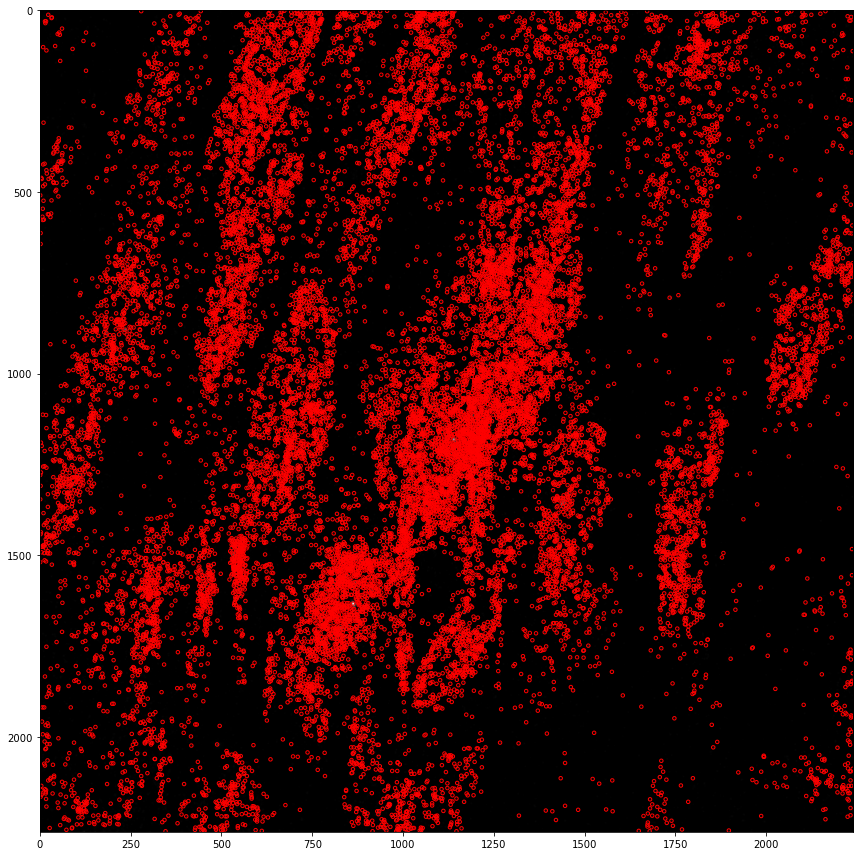

In [ ]:
adjusted_im = rescale_intensity(mip_im)
fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.imshow(img_as_ubyte(adjusted_im), cmap='gray')
ax.scatter(coors[:,1],coors[:,0],s=12,facecolor='none',edgecolor='r')
plt.tight_layout()
plt.savefig('threshold check gene6.png',dpi=300)

In [ ]:
dots_df = pd.DataFrame(dots)

In [ ]:
df_by_gene = dots_df.groupby('gene')

In [ ]:
cycle1_dfs = [df_by_gene.get_group('005_gene1'),df_by_gene.get_group('005_gene2'),df_by_gene.get_group('005_gene3')]
cycle2_dfs = [df_by_gene.get_group('005_gene4'),df_by_gene.get_group('005_gene5'),df_by_gene.get_group('005_gene6')]

In [ ]:
cycle1_dfs = pd.concat(cycle1_dfs)
cycle2_dfs = pd.concat(cycle2_dfs)

In [ ]:
cycle1_by_gene = cycle1_dfs.groupby('gene')

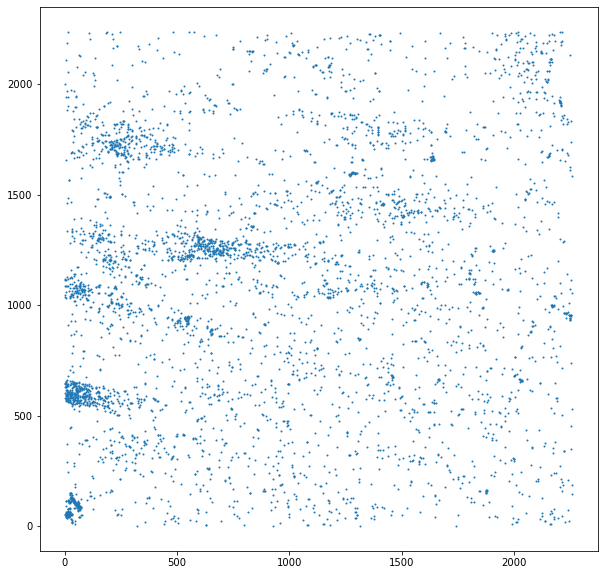

In [ ]:
sub_df = cycle1_by_gene.get_group('005_gene1')
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(sub_df['row'].tolist(), sub_df['col'].tolist(),s=1)

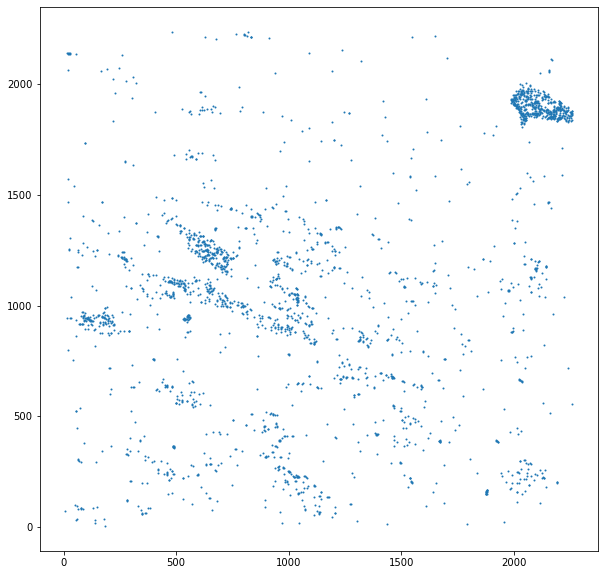

In [ ]:
sub_df = cycle1_by_gene.get_group('005_gene2')
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(sub_df['row'].tolist(), sub_df['col'].tolist(),s=1)

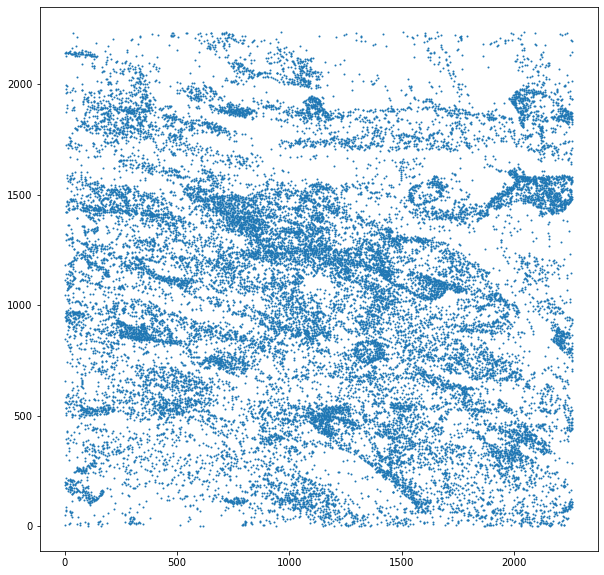

In [ ]:
sub_df = cycle1_by_gene.get_group('005_gene3')
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(sub_df['row'].tolist(), sub_df['col'].tolist(),s=1)

In [ ]:
cycle1_dfs['z'] = cycle1_dfs['z'] - 63
cycle2_dfs['z'] = cycle2_dfs['z'] - 69

In [ ]:
dots_df = pd.concat([cycle1_dfs,cycle2_dfs])
df_by_gene = dots_df.groupby('gene')
genes = dots_df['gene'].unique().tolist()
genes.sort()

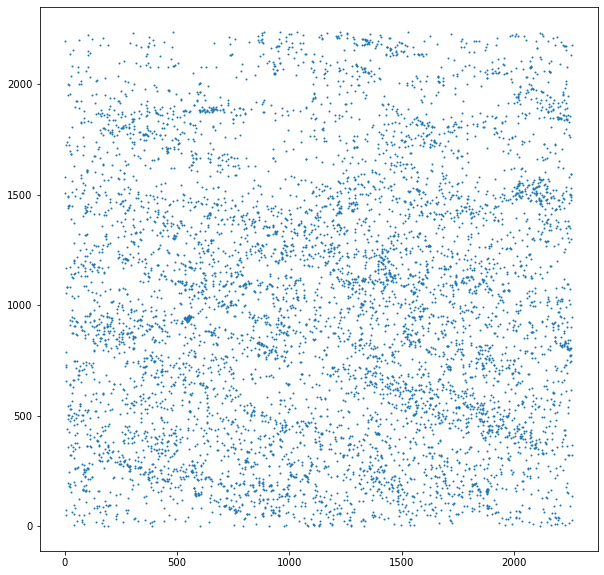

In [ ]:
sub_df = df_by_gene.get_group('005_gene4')
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(sub_df['row'].tolist(), sub_df['col'].tolist(),s=1)

In [ ]:
gene_color_dict = {'005_gene1':'#ff0000', '005_gene2':'#00ff00',
                   '005_gene3':'#0000ff', '005_gene4':'#ff00ff',
                   '005_gene5':'#ffff00', '005_gene6':'#00ffff'}
genes = list(gene_color_dict.keys())

In [ ]:
scale = 249.6/2304
z_scale = 249.6/2304

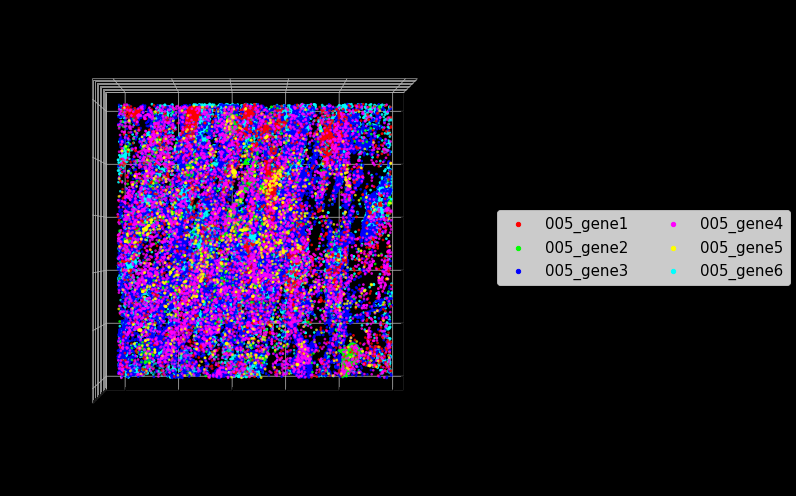

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
for g in genes:
    sub_group = df_by_gene.get_group(g)
    c = gene_color_dict[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 0)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
# plt.savefig(r'.\figures\009_pbmc_3 top view.png')

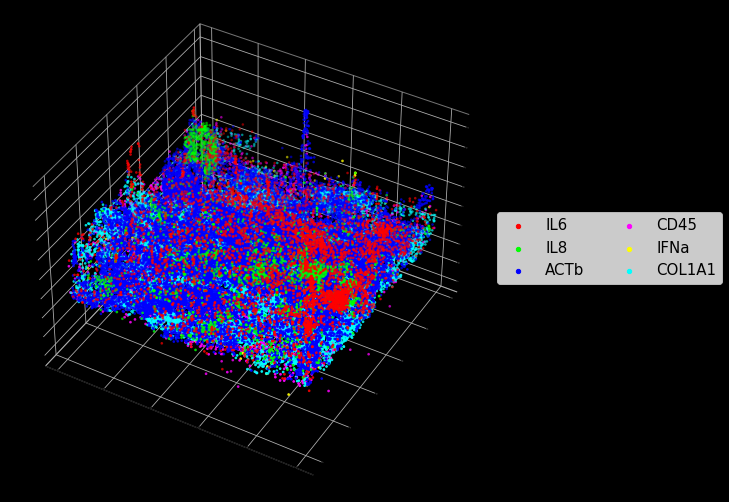

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
for i,g in enumerate(genes):
    l = genes_label['set1'][i]
    sub_group = df_by_gene.get_group(g)
    c = gene_color_dict[g]
    ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=l)
ax.view_init(-140, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\fov005_dots_scatter.png')

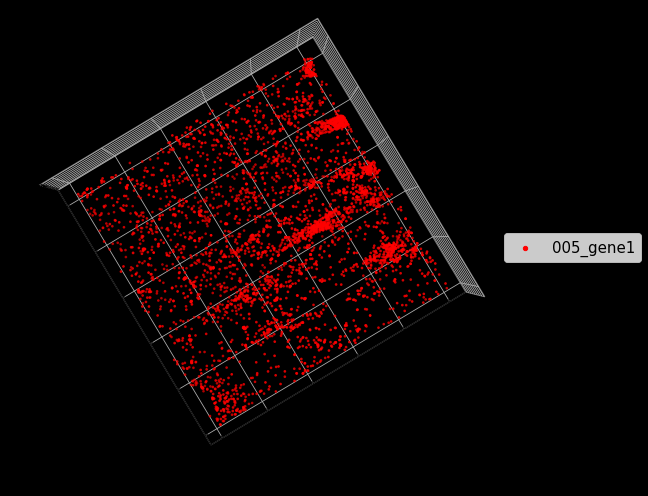

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
g = genes[0]
c = gene_color_dict[g]
sub_group = df_by_gene.get_group(g)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\005_gene1.png')

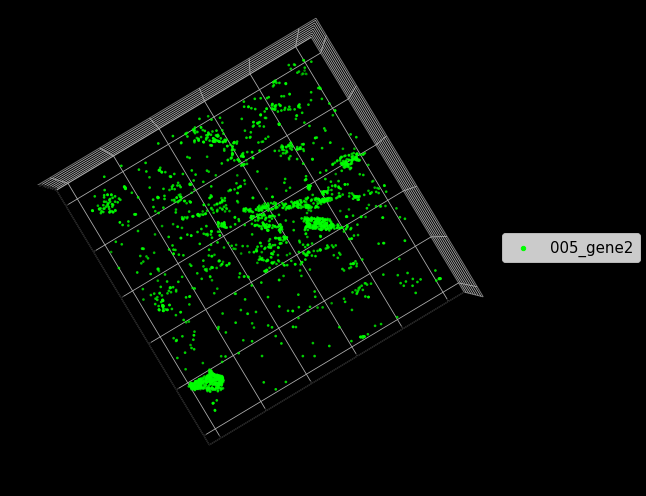

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
g = genes[1]
c = gene_color_dict[g]
sub_group = df_by_gene.get_group(g)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\005_gene2.png')

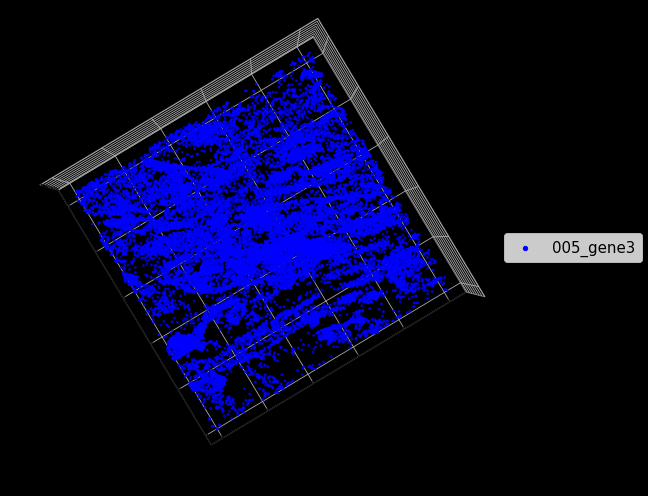

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
g = genes[2]
c = gene_color_dict[g]
sub_group = df_by_gene.get_group(g)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\005_gene3.png')

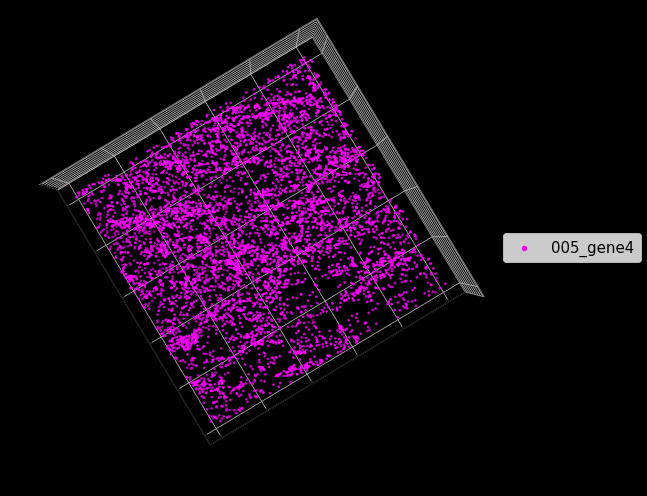

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
g = genes[3]
c = gene_color_dict[g]
sub_group = df_by_gene.get_group(g)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\005_gene4.png')

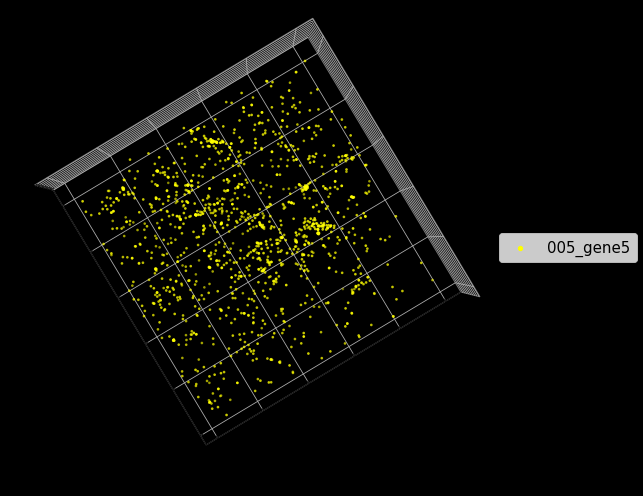

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
g = genes[4]
c = gene_color_dict[g]
sub_group = df_by_gene.get_group(g)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 60)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\005_gene5.png')

KeyError: 5

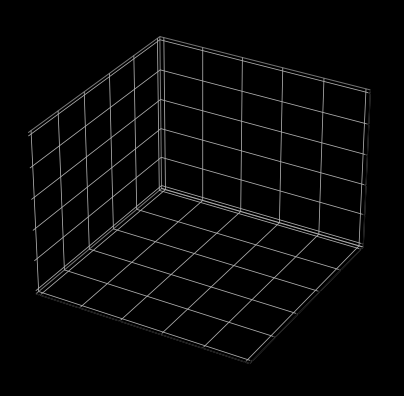

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.invert_zaxis()
# ax.scatter(center[0]*scale,center[1]*scale,center[2]*z_scale,color='r',s=2000)
# ax.scatter(dapi_df[0].to_numpy()*scale,dapi_df[1].to_numpy()*scale,dapi_df[2].to_numpy()*z_scale,color='b',s=1)
g = genes[5]
c = gene_color_dict[g]
sub_group = df_by_gene.get_group(g)
ax.scatter(sub_group['row']*scale,sub_group['col']*scale,sub_group['z']*z_scale,'.',color=c,s=3,label=g)
ax.view_init(90, 0)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5),ncol=2,fontsize=15,markerscale=2.5)

plt.tight_layout()
plt.savefig(r'..\..\figures\005_gene6.png')

In [ ]:
genes_label = {'set1':['IL6','IL8','ACTb','CD45','IFNa','COL1A1'],
         'set2':['COL1A1','HLA-DRA','IL10','PD1','PDL1','GAPDH'],
         'set3':['TNFa','PDL1','COL5A2','CCL11','COL2A1','CXCL10'],
         'set4':['MKI67','COL2A1','CXCR4','ACTb','IFNg','CD34']}

In [ ]:
with open('gene_set.pkl', 'wb') as f:
    pickle.dump(genes, f)

## batch detection

In [ ]:
in_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered'
fov_l = os.listdir(in_dir)
fov_l.sort()

In [ ]:
fov_l = fov_l[:120]

In [ ]:
out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\detected_dots'

In [ ]:
for fov in tqdm(fov_l):
    
    cycle1_mips = []
    cycle1_mips.append(tifffile.imread(os.path.join(in_dir,fov,'cycle1_mip_C2.tif')))
    cycle1_mips.append(tifffile.imread(os.path.join(in_dir,fov,'cycle1_mip_C3.tif')))
    cycle1_mips.append(tifffile.imread(os.path.join(in_dir,fov,'cycle1_mip_C4.tif')))

    cycle1_stacks = []
    cycle1_stacks.append(tifffile.imread(os.path.join(in_dir,fov,'cycle1_stack_C2.tif')))
    cycle1_stacks.append(tifffile.imread(os.path.join(in_dir,fov,'cycle1_stack_C3.tif')))
    cycle1_stacks.append(tifffile.imread(os.path.join(in_dir,fov,'cycle1_stack_C4.tif')))
    
    cycle2_mips = []
    cycle2_mips.append(tifffile.imread(os.path.join(in_dir,fov,'cycle2_mip_C2.tif')))
    cycle2_mips.append(tifffile.imread(os.path.join(in_dir,fov,'cycle2_mip_C3.tif')))
    cycle2_mips.append(tifffile.imread(os.path.join(in_dir,fov,'cycle2_mip_C4.tif')))

    cycle2_stacks = []
    cycle2_stacks.append(tifffile.imread(os.path.join(in_dir,fov,'cycle2_stack_C2.tif')))
    cycle2_stacks.append(tifffile.imread(os.path.join(in_dir,fov,'cycle2_stack_C3.tif')))
    cycle2_stacks.append(tifffile.imread(os.path.join(in_dir,fov,'cycle2_stack_C4.tif')))
    
    dots = {'row':[], 'col':[], 'z':[], 'gene':[]}
    for i in range(3):
        mip_im = cycle1_mips[i]
        coors = peak_local_max(mip_im, threshold_abs = threshold_triangle(mip_im)*1.2)
        dots['row'] = dots['row'] + list(coors[:,0])
        dots['col'] = dots['col'] + list(coors[:,1])
        stack_im = cycle1_stacks[i]
        z = Parallel(n_jobs=8)(delayed(find_max)(stack_im,coor) for coor in list(zip(list(coors[:,0]),list(coors[:,1]))))
        dots['z'] = dots['z'] + z
        dots['gene'] = dots['gene'] + [fov + '_gene' + str(i+1)]*len(z)
    
    for i in range(3):
        mip_im = cycle2_mips[i]
        coors = peak_local_max(mip_im, threshold_abs = threshold_triangle(mip_im)*1.2)
        dots['row'] = dots['row'] + list(coors[:,0])
        dots['col'] = dots['col'] + list(coors[:,1])
        stack_im = cycle2_stacks[i]
        z = Parallel(n_jobs=8)(delayed(find_max)(stack_im,coor) for coor in list(zip(list(coors[:,0]),list(coors[:,1]))))
        dots['z'] = dots['z'] + z
        dots['gene'] = dots['gene'] + [fov + '_gene' + str(i+4)]*len(z)
    
    df = pd.DataFrame(dots)
    df.to_csv(os.path.join(out_dir,fov+'_dots.csv'))

100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [1:31:06<00:00, 45.55s/it]


In [ ]:
dots_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\detected_dots'
fov_l = os.listdir(dots_dir)
fov_l.sort()

In [ ]:
out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\corrected_dots'

In [ ]:
for fov_name in tqdm(fov_l):
    if fov_name.endswith('.csv'):
        fov = fov_name.split('_')[0]
        dots = pd.read_csv(os.path.join(dots_dir, fov_name),index_col=0)
        dots_by_gene = dots.groupby('gene')
        
        cycle1_gene = pd.concat([dots_by_gene.get_group(fov+'_gene1'),
                                 dots_by_gene.get_group(fov+'_gene2'),
                                 dots_by_gene.get_group(fov+'_gene3')])
        z = np.sort(cycle1_gene['z'].unique())
        slices = np.zeros(z.shape[0]-2)
        for i in range(slices.shape[0]):
            z_min = z[i]
            z_max = z[i+2]
            temp = cycle1_gene[cycle1_gene['z'] >= z_min]
            temp = temp[temp['z'] <= z_max]
            slices[i] = temp.shape[0]
        cycle1_gene['z'] = cycle1_gene['z'] - z[np.argmax(slices)+1]
        
        cycle2_gene = pd.concat([dots_by_gene.get_group(fov+'_gene4'),
                                 dots_by_gene.get_group(fov+'_gene5'),
                                 dots_by_gene.get_group(fov+'_gene6')])
        z = np.sort(cycle2_gene['z'].unique())
        slices = np.zeros(z.shape[0]-2)
        for i in range(slices.shape[0]):
            z_min = z[i]
            z_max = z[i+2]
            temp = cycle2_gene[cycle2_gene['z'] >= z_min]
            temp = temp[temp['z'] <= z_max]
            slices[i] = temp.shape[0]
        cycle2_gene['z'] = cycle2_gene['z'] - z[np.argmax(slices)+1]
        
        corrected_dots = pd.concat([cycle1_gene, cycle2_gene])
        corrected_dots.to_csv(os.path.join(out_dir,fov_name))

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:54<00:00,  2.22it/s]


# KI67 quantification

In [11]:
from skimage.measure import regionprops,regionprops_table

In [12]:
mask_dir = r'..\..\coculture_diagonal\primed_pbmc\00_masks\pbmc_masks_2d\cd8'
ki67_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\KI67'
fov_l = os.listdir(ki67_dir)
fov_l.sort()

In [13]:
ki67_dict = {'cellID':[],'row':[],'col':[],'KI67':[]}
for fov in tqdm(fov_l):
    mask = img_as_uint(tifffile.imread(os.path.join(mask_dir,fov+'_mask.tif')))
    ki67 = tifffile.imread(os.path.join(ki67_dir,fov,'C4_'+fov+'_KI67.tif'))
    ki67 = img_as_float(ki67)
    ki67 = rescale_intensity(ki67)
    props = regionprops_table(mask,ki67,properties=['label','mean_intensity','centroid'])
    cell_id = [fov+'_'+str(i) for i in props['label']]
    ki67_dict['cellID'] = ki67_dict['cellID'] + cell_id
    ki67_dict['row'] = ki67_dict['row'] + list(props['centroid-0'])
    ki67_dict['col'] = ki67_dict['col'] + list(props['centroid-1'])
    ki67_dict['KI67'] = ki67_dict['KI67'] + list(props['mean_intensity'])

  0%|          | 0/120 [00:00<?, ?it/s]c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\skimage\util\dtype.py:482: UserWarning: Downcasting int32 to uint16 without scaling because max value 2 fits in uint16
  return _convert(image, np.uint16, force_copy)
  1%|          | 1/120 [00:00<01:17,  1.53it/s]c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\skimage\util\dtype.py:482: UserWarning: Downcasting int32 to uint16 without scaling because max value 4 fits in uint16
  return _convert(image, np.uint16, force_copy)
  2%|▏         | 2/120 [00:01<01:07,  1.75it/s]c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\skimage\util\dtype.py:482: UserWarning: Downcasting int32 to uint16 without scaling because max value 3 fits in uint16
  return _convert(image, np.uint16, force_copy)
  2%|▎         | 3/120 [00:01<01:05,  1.77it/s]c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\skimage\util\dtype.py:482: UserWarning: Downcasting int32 to uint16 without scaling because max val

In [16]:
ki67_df = pd.DataFrame(ki67_dict)

In [17]:
ki67_df.to_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cd8_ki67_intensity.csv')

# Masking ki67 images

In [10]:
ki67_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\KI67'
mask_dir = r'..\..\coculture_diagonal\primed_pbmc\00_masks\all_cells'
fov_l = os.listdir(ki67_dir)
fov_l.sort()

out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_registered\masked_ki67'

In [12]:
for fov in tqdm(fov_l):
    ki67_im = tifffile.imread(os.path.join(ki67_dir,fov,'C4_'+fov+'_KI67.tif'))
    mask = tifffile.imread(os.path.join(mask_dir,fov+'_mask.tif'))
    binarry_mask = mask > 0
    masked_ki67 = ki67_im*binarry_mask
    tifffile.imwrite(os.path.join(out_dir,'masked_'+fov+'_ki67.tif'),img_as_uint(masked_ki67),imagej=True)

100%|██████████| 120/120 [01:06<00:00,  1.79it/s]
